# Student Academic Performance Prediction

## Fourth Notebook: Model Interpretation, Analysis, and Actionable Insights

Following the modeling and sensitivity analysis conducted in the previous phase, this final notebook focuses on the synthesis and interpretation of the findings. At this stage, the analysis transitions from pure prediction to the extraction of meaningful intelligence that can inform educational decision-making.

The analysis in this phase is organized around three strategic pillars:

**1-Dropout & Critical Failure Analysis**

Students who achieved a final grade of zero are isolated and profiled. By re-extracting these cases from the raw data, the objective is to identify contextual and behavioral triggers, such as extreme absences or specific family dynamics, that differentiate administrative failure from standard academic struggle.

**2-Performance Synthesis**

Results obtained across the different modeling scenarios are examined. This involves evaluating the effectiveness of parsimonious feature sets and assessing how early academic momentum outweighs socio-economic variables in predicting final outcomes.

**3-Actionable Insights & Recommendations**

Based on the predictive patterns identified, concrete interventions for school administrators are proposed. These insights focus on early academic risk identification and the optimization of support resources to prevent dropouts and improve overall student success.

By bridging the gap between complex data modeling and practical implementation, this notebook provides the final strategic layer of the study, turning predictive accuracy into a tool for academic resilience.

**Author:** J-F Jutras  
**Date:** January 2026  
**Dataset:** Student Performance — UCI / Kaggle (Portuguese Secondary Education)


## 4.1-Data Loading

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
import sys
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

#Direct Loading
dataset_dir = "/kaggle/input/acamedicperfomance"
df_port_raw = pd.read_csv(os.path.join(dataset_dir, "student_language.csv"), sep=";")
df_math_raw = pd.read_csv(os.path.join(dataset_dir, "student_math.csv"), sep=";")

#Isolating Dropouts (G3 == 0)
port_dropouts = df_port_raw[df_port_raw['G3'] == 0].copy()
math_dropouts = df_math_raw[df_math_raw['G3'] == 0].copy()
df_all_dropouts = pd.concat([port_dropouts, math_dropouts], axis=0).reset_index(drop=True)

#Manual definition of Minimal Features
port_minimal = ['G2', 'G1', 'absences', 'failures', 'school'] 
math_minimal = ['G2', 'G1', 'absences', 'failures', 'goout']

#Utilities
!rm -rf /kaggle/working/jfj-utils
!git clone https://github.com/jfjutras07/jfj-utils.git
sys.path.append("/kaggle/working/jfj-utils")

### Column Description

| Variable | Description | Variable | Description |
|---------|-------------|---------|-------------|
| school | Student's school (GP or MS) | sex | Student's sex (F or M) |
| age | Student's age (15–22) | address | Home address type (Urban or Rural) |
| famsize | Family size (≤3 or >3) | Pstatus | Parents' cohabitation status |
| Medu | Mother's education level (0–4) | Fedu | Father's education level (0–4) |
| Mjob | Mother's occupation | Fjob | Father's occupation |
| reason | Reason for choosing the school | guardian | Student's guardian |
| traveltime | Home-to-school travel time (1–4) | studytime | Weekly study time (1–4) |
| failures | Number of past class failures | schoolsup | Extra educational support |
| famsup | Family educational support | paid | Extra paid classes (subject-specific) |
| activities | Extra-curricular activities | nursery | Attended nursery school |
| higher | Intention to pursue higher education | internet | Internet access at home |
| romantic | In a romantic relationship | famrel | Family relationship quality (1–5) |
| freetime | Free time after school (1–5) | goout | Going out with friends (1–5) |
| Dalc | Workday alcohol consumption (1–5) | Walc | Weekend alcohol consumption (1–5) |
| health | Current health status (1–5) | absences | Number of school absences |
| G1 | First period grade (0–20) | G2 | Second period grade (0–20) |
| G3 | Final grade (0–20) |  |  |


## 4.2-Dropout Analysis

Dropouts are identified as students with a terminal failure ($G3 = 0$), including those who abandoned the curriculum mid-year ($G2 = 0$ and $G3 = 0$). This criteria isolates permanent academic attrition while intentionally excluding "resilient" students who may have failed the first period ($G1 = 0$) but successfully recovered by the end of the academic year.

The internal profiling results show a higher degree of reliability for the Mathematics cohort (n=38). For the Portuguese cohort (n=15), the small sample size means that correlations are highly sensitive to individual outliers. Therefore, the Portuguese results are presented as preliminary trends that warrant further investigation with a larger population.

In [ ]:
#Correlation Analysis - Portuguese dataset
numeric_features = [
    'age', 
    'Medu', 
    'Fedu', 
    'traveltime', 
    'studytime', 
    'failures', 
    'famrel', 
    'freetime', 
    'goout', 
    'Dalc', 
    'Walc', 
    'health', 
    'absences', 
    'G1',   
    'G2'
  ]

from visualization.explore_continuous import plot_correlation_heatmap
plot_correlation_heatmap(port_dropouts, numeric_features, method = 'spearman')

Given the very small sample size of dropouts in the Portuguese dataset, these correlations must be interpreted with caution as indicative trends rather than broad generalizations. In Portuguese, the dropout is less about academic struggle and more about logistical and social detachment.

- High traveltime shows a significant link with declining health (-0.35), characterizing a student exhausted by external constraints rather than defeated by the curriculum.

- A strong positive correlation between goout and G1 (0.43) suggests that these dropouts are often socially integrated and initially capable, but their academic engagement is eventually overtaken by social priorities.

- The powerful link between past failures and poor family relations (-0.47) indicates that the mid-year crash is often triggered by a lack of emotional support or a deteriorating home environment.

In [ ]:
#Correlation Analysis - Mathematics dataset
plot_correlation_heatmap(math_dropouts, numeric_features, method = 'spearman')

In Mathematics, the dropout profile is significantly different from Portuguese, focusing on academic momentum and structural support.

- There is a very strong correlation between studytime and G1 (0.53). Unlike Portuguese, those who drop out in Math often show a direct collapse when their early academic effort is insufficient to master the cumulative nature of the subject.

- A high correlation between Fedu (Father's education) and G1 (0.42) suggests that for potential dropouts, paternal academic support or background is a key factor in maintaining early grades before the final crash.

- A very strong negative correlation exists between health and G2 (-0.57). This indicates that for Math dropouts, physical well-being (or lack thereof) is a primary driver of the mid-year performance drop, more so than social factors.

In [ ]:
#Create the persistent groups (G3 > 0) to allow clean comparisons
#This ensures we compare "Dropouts" vs "Successful students" without overlap
port_persistent = df_port_raw[df_port_raw['G3'] > 0].copy()
math_persistent = df_math_raw[df_math_raw['G3'] > 0].copy()

print(f"Preparation complete:")
print(f"Port: {len(port_dropouts)} dropouts vs {len(port_persistent)} persistent")
print(f"Math: {len(math_dropouts)} dropouts vs {len(math_persistent)} persistent")

In [ ]:
!pip install -q pingouin scikit-bio scikit-posthocs

#Import library
import pingouin as pg

#Filter out grades from candidate features
potential_features = [f for f in numeric_features if f not in ['G1', 'G2', 'G3']]

#Select top 5 non-grade features by Spearman correlation with G3
port_features = (
    df_port_raw[potential_features + ['G3']]
    .corr(method='spearman')['G3']
    .drop('G3')
    .abs()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

math_features = (
    df_math_raw[potential_features + ['G3']]
    .corr(method='spearman')['G3']
    .drop('G3')
    .abs()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

def simple_analysis(df_drop, df_persist, features, label):
    results = []
    for feat in features:
        test = pg.mwu(df_drop[feat], df_persist[feat])
        results.append({
            'Feature': feat,
            'p-val': test['p-val'].iloc[0],
            'CLES': test['CLES'].iloc[0],
            'RBC': test['RBC'].iloc[0]
        })
    return pd.DataFrame(results)

port_res = simple_analysis(port_dropouts, port_persistent, port_features, "Portuguese")
math_res = simple_analysis(math_dropouts, math_persistent, math_features, "Math")

display(port_res, math_res)

**Key Feature Comparison — Dropout vs Persistent (Portuguese & Mathematics)**

| Feature   | Portuguese Dropout (Mean) | Math Dropout (Mean) | Significance (p-val) | Effect Size (RBC) | Key Insight |
|-----------|---------------------------|---------------------|----------------------|-------------------|-------------|
| Failures  | 0.80 (vs 0.21)            | 0.92 (vs 0.27)      | < 0.001 (Both)       | 0.45 / 0.36       | **Universal Driver**: Prior academic debt is the strongest predictor for both subjects. |
| Medu (Mother) | 2.27                  | 2.32 (vs 2.80)      | 0.007 (Math)         | -0.25             | **Math Anchor**: Maternal education is a critical structural barrier specifically in Mathematics. |
| Fedu (Father) | 2.29 (vs 2.50)        | 2.29                | 0.019 (Port)         | -0.34             | **Port Anchor**: Paternal background plays a more significant protective role in language/humanities. |
| Studytime | 1.47 (vs 1.94)            | 1.97                | 0.027 (Port)         | -0.31             | **Engagement**: Port dropouts show a clear deficit in effort; Math dropouts study more but still fail. |
| Age       | 17.01                     | 17.08 (vs 16.65)    | 0.038 (Math)         | 0.19              | **Maturity**: Older students hit a “content ceiling” more severely in the cumulative Math curriculum. |


## 4.3-Academic Performance Synthesis

### Pre-Grade Overall Predictive Performance

Assuming certain variables are available at the start of the academic year (notably historical records of past failures and absenteeism from previous cycles, as the exact collection timeline remains unconfirmed) the pre-grade scenarios identify high-value strategic indicators despite a low predictive ceiling ($R^2 \approx 0.24$ for Portuguese and $0.27$ for Math). This phase shifts the focus from grade estimation to structural stratification, highlighting three key observable pillars:

- The model identifies a "risk-cluster" primarily driven by **past failures and historical absenteeism**. These are the strongest indicators of a fragile academic foundation, surfacing students who are statistically predisposed to struggle before a single new grade is recorded.

- The sensitivity analysis confirms that a history of **poor health** acts as a significant vulnerability marker, particularly in STEM (Mathematics). This suggests that students with physical or psychological fragility are more susceptible to cumulative knowledge gaps, making health a primary non-academic predictor.

- The variable **higher (desire for higher education)** stands out as a critical psychological anchor. Students marked as "unsure" or "no" exhibit a lack of long-term academic commitment, which the model identifies as a precursor to lower effort and eventual underperformance.

Ultimately, the value of the pre-grade model lies in proactive positioning. By identifying these elements in September rather than waiting for the $G1$ failures in November, the model isolates the contextual vulnerability of the student before it translates into academic failure.

In [ ]:
from visualization.explore_continuous import plot_box_plot

#Add identification columns to both datasets
port_persistent['Subject'] = 'Portuguese'
math_persistent['Subject'] = 'Math'

#Combine datasets to allow a single comparative visualization
df_combined = pd.concat([port_persistent, math_persistent]).reset_index(drop=True)

#Generate the plot
plot_box_plot(df_combined, ['G3'], 'higher', hue_col='Subject')

### First-term predictive performance

The integration of G1 (First-Term Grade) as a primary predictor establishes a robust performance baseline ($R^2 \approx 0.70$), yet it leaves a critical 30% of variance unexplained. At this specific juncture in the academic calendar, the student’s trajectory is not yet finalized, transforming this "unexplained" portion into a high-stakes area for early administrative intervention.

**Model Bias vs Real-World Dynamics — Portuguese**

| Factor         | Correlation | Model Bias       | Real-World Student Dynamics |
|----------------|-------------|------------------|-----------------------------|
| Famrel (Family Quality) | +0.1656 | Underestimation | A healthy family climate acts as a silent success lever that the linear model fails to fully quantify. |
| Goout (Socializing)     | +0.0528 | Underestimation | An active social life is less detrimental to language arts than the model's rigid logic assumes. |
| G1 (First Term Grade)   | -0.1216 | Over-optimism  | The model “trusts” the initial grade too much and fails to predict the late-year academic slowdown. |
| Studytime               | -0.0842 | Over-optimism  | Declared study hours are statistically less effective than the model predicts for the final outcome. |
| Absences_log            | -0.0501 | Over-optimism  | The model slightly minimizes how much missing class erodes linguistic mastery by the end of the year. |


**Model Bias vs Real-World Dynamics — Mathematics (Extended Factors)**

| Factor               | Correlation | Model Bias       | Real-World Student Dynamics |
|----------------------|-------------|------------------|-----------------------------|
| Alcohol_Index        | +0.1503     | Underestimation  | Paradox: More “social” students (higher index) bounce back better than the model predicts, likely due to peer study groups. |
| Parental_Edu_Level   | +0.0918     | Underestimation  | Parental “cultural capital” helps students bridge math gaps better than the raw data suggests. |
| Absences_log         | -0.1863     | Over-optimism   | In Math, missing class is fatal. The model fails to penalize the “snowball effect” of missed cumulative concepts. |
| Failures (Past)      | -0.1486     | Over-optimism   | Past failure is a psychological and technical weight that the model underestimates for the final stretch. |
| Traveltime / Age     | -0.1400     | Fatigue Bias    | Older students or those commuting long distances experience a “burnout” effect that drops their grade below the AI’s prediction. |


**Graphic**

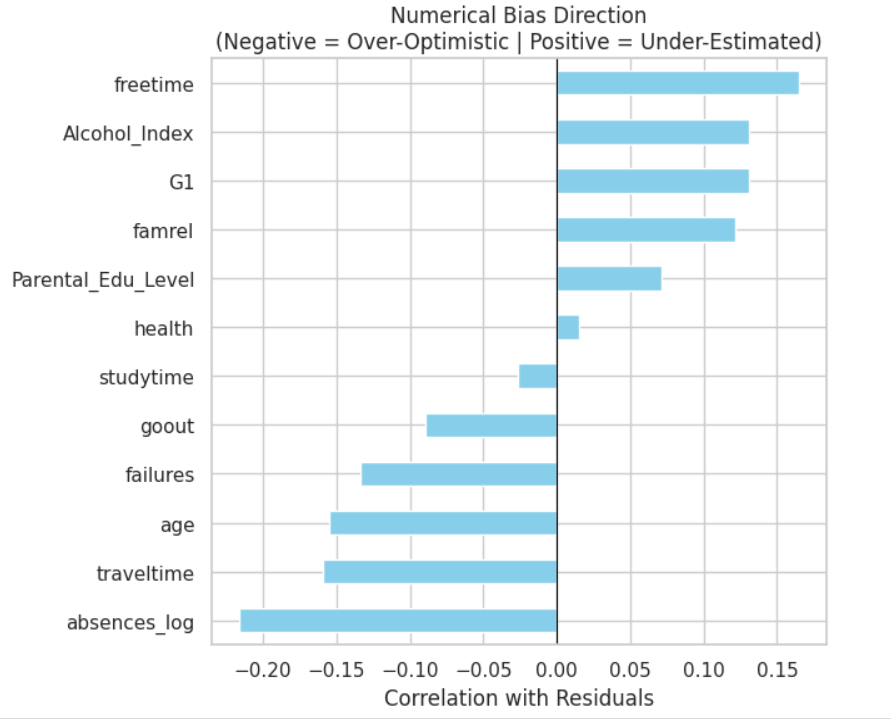

The analysis shifts from identifying static profiles to auditing the factors of divergence:

- While G1 provides a strong anchor, it is not a final verdict. The model identifies a "performance gap" where students with similar grades start to diverge based on their absenteeism and past failures. This proves that early grades can be deceptive if not weighted against the student’s historical stability.

- In Mathematics, the model reveals that health and travel fatigue begin to act as "silent anchors." Even students with a passing G1 are at risk of a mid-year drop if they face long commutes or physical fragility, factors that the Random Forest captures as non-linear threats to STEM mastery.

- For both subjects, parental education and home internet access emerge as stabilizers. Students with these resources are more likely to "recover" from a mediocre G1, whereas students lacking this cultural capital tend to follow a downward trajectory if their first-term results are weak.

The value of the **G1-integrated model** lies in identifying "at-risk pass rates." By analyzing the residuals, the model flags students who have passing grades but possess high-friction traits (absences, fatigue, low ambition). This allows schools to intervene before a fragile passing grade in November turns into a definitive failure in June.

### Last-term predictive performance

The final refinement stage marks the transition from a broad research framework to a Practical Diagnostic Tool. By distilling the feature set down to a core nucleus of just five variables, we evaluate the "last mile" of predictive efficiency. This phase confirms that academic momentum, when balanced with specific behavioral friction, allows for high-accuracy modeling with minimal data collection effort.

- The benchmarking results prove that a 5-variable model for Portuguese—focusing on **G2, G1, absences, school, and past failures** retains over 98% of the predictive power of the full 40+ feature set. The Lasso model ($R^2=0.86$) identifies that linguistic mastery follows a stable, additive trajectory where previous academic history is the primary anchor.

- In Mathematics, the "Minimalist Nucleus" of **G2, G1, absences, reason for choosing school (home), and age** achieves its peak performance through XGBoost ($R^2=0.83$). This highlights that STEM success is more sensitive to non-linear interactions, such as how age and absenteeism can compound to create a "snowball effect" that a linear model would fail to penalize sufficiently.

- The high Cross-Validation Robustness (up to 0.91 for Math) confirms that these parsimonious models are not overfitted to a specific data split. By selecting these five specific predictors, we offer a lean solution that minimizes administrative burden while maximizing the reliability of early warning alerts.

## 4.4-Actionable Insights

The following plan translates the modeling results into a structured timeline for school administrators. This strategy acknowledges the lack of access to internal financial data and focuses on academic risk management and data governance optimization.The goal is to move the administrative focus from simply recording final outcomes ($G3$) to proactively managing the high-stakes period between $G1$ and $G2$.

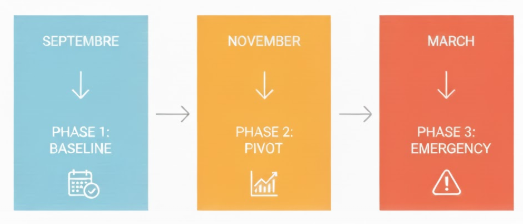 

### Baseline (Pre-Grade)

| Phase | Monitoring Focus (The Core Predictors) | Rationale (Backing Data) | Actionable Intervention |
|-------|--------------------------------------|--------------------------|-------------------------|
| Baseline (Pre-Grade) | **1. Academic Debt: Failures**<br>(Number of past class failures) | **Universal Driver**: Prior failure is the strongest predictor of terminal failure (G3 = 0) in both subjects. | **Early Support**: Immediate enrollment in “Catch-up” workshops or study halls for any student with failures > 0. |
| Baseline (Pre-Grade) | **2. Contextual Friction: School and Age** | **Maturity Gap**: Older students in Math show a higher risk of hitting a “content ceiling” or experiencing burnout. | **Structural Adjustment**: Reviewing schedules or providing additional tutoring for older students in cumulative STEM subjects. |
| Baseline (Pre-Grade) | **3. Structural Attendance: Historical Absences** | **Erosion Factor**: High historical absences predict low G1 performance, especially in the cumulative Math curriculum. | **Attendance Contract**: Early meeting with parents and students to establish a commitment to physical presence in class. |



### Pivot (Post-G1)

| Phase | Monitoring Focus (The Core Predictors) | Rationale (Backing Data) | Actionable Intervention |
|-------|--------------------------------------|--------------------------|-------------------------|
| Pivot Point (Post-G1) | **1. Academic Momentum: G1 Grade vs. Failures** | **Stability Check**: In Portuguese, linguistic mastery is additive. If a student has a low G1 and prior failures, their trajectory is statistically unlikely to recover without intervention. | **Targeted Tutoring**: Mandatory content reinforcement for students where G1 confirms the risk identified at the baseline. |
| Pivot Point (Post-G1) | **2. Real-Time Friction: Absences (Trend Analysis)** | **The Snowball Effect**: In Math, G1 performance is highly sensitive to attendance. Missing concepts early leads to a non-linear collapse by G2. | **Immediate Recovery**: Trigger “bridge sessions” for any student whose absences spike after the first assessment to prevent a total disconnect. |
| Pivot Point (Post-G1) | **3. The “Fragile Passer” Signal**<br>(Passing G1 + High Risk Markers) | **Model Bias Correction**: Models often “trust” a passing G1 too much. Students with a 10/20 but high absences or low ambition (higher = no) are high-probability late-year dropouts. | **Prevention Interview**: Proactive meetings with “fragile passers” to address non-academic factors (fatigue, motivation) that lead to a late-year G2/G3 crash. |


### Emergency (Post-G2)

| Phase | Monitoring Focus (The Core Predictors) | Rationale (Backing Data) | Actionable Intervention |
|-------|--------------------------------------|--------------------------|-------------------------|
| Emergency (Post-G2) | **1. Terminal Trajectory: G2 Grade + G1 Trend** | **The Point of No Return**: A failing G2 combined with a stagnant G1 indicates a finalized downward trend. | **Intensive Recovery**: Implementation of a “Rescue Plan” (Individualized Learning Plan) specifically designed to secure the minimum passing grade for G3. |
| Emergency (Post-G2) | **2. Non-Linear Friction: Absences + Age**<br>(Math Focus) | **The Content Ceiling**: In Mathematics, older students or those with high absences at this stage hit a “content ceiling” where cumulative gaps become insurmountable. | **Curriculum Modification**: For critical cases, focus exclusively on the core competencies required to pass the year, reducing elective friction or non-essential workload. |
| Emergency (Post-G2) | **3. The Dropout Signal**<br>(G2 = 0 or High “Minimalist” Risk) | **Attrition Identification**: Students identified by the 5-variable model as having a 98% probability of failure are at immediate risk of administrative or social dropout. | **Parent–Administrative Summit**: Final intervention involving family and school leadership to address specific “Silent Anchors” (health, travel fatigue) before the final exams. |


**Key Takeaways**

- **Process over complexity**: The effectiveness of academic risk management depends less on advanced models than on clear, repeatable human processes that act on predictive signals.

- **Fewer indicators, higher impact**: Monitoring a focused set of approximately ten high-impact indicators is more effective than tracking dozens of variables. This ensures data quality, interpretability, and operational sustainability.

- **From static data to actionable signals**: Dynamic measures (e.g., recent absence trends or concrete logistical disruptions) provide more actionable insight than static or annual aggregates.

- **Early identification beyond grades**: Students with passing grades but high friction markers (“fragile passers”) represent a critical blind spot and must be flagged immediately after G1.

- **Structured follow-up is essential**: Dashboards, regular multidisciplinary risk meetings, and clearly defined intervention tiers are necessary to convert predictions into outcomes.

- **Shift in objective**: The ultimate goal is not to predict final failure (G3 = 0), but to manage the friction that leads to it.

## 4.5-Limitations

| Limitation | Explanation |
|-----------|-------------|
| **Limited organizational data** | The analysis relies on a restricted set of institutional variables; internal academic support policies, individualized adjustments, and informal interventions are not fully captured. |
| **External contextual factors** | Broader socio-economic and environmental influences (e.g., family instability, health events, transportation disruptions) are not directly observed and may affect student trajectories. |
| **Unobserved individual factors** | Cognitive load, motivation dynamics, mental health conditions, and informal learning behaviors are not explicitly measured in the dataset. |
| **Small high-risk subgroup sizes** | The limited number of extreme outcomes (e.g., confirmed dropouts or terminal failures) reduces statistical power and constrains strong generalization. |
| **Incomplete behavioral determinants** | Self-reported behaviors (study time, extracurricular load) may be imprecise, and certain latent factors influencing engagement remain unobserved. |
| **Single-time snapshot (Pre-Grade models)** | Baseline models rely on pre-assessment data; without G1/G2 results, predictive accuracy remains inherently capped and focuses on risk rather than exact outcomes. |
| **Disciplinary non-linearity** | Subject-specific dynamics, particularly in Mathematics, involve cumulative learning effects that are insufficiently captured by linear modeling approaches. |
| **Potential residual confounding** | Interactions among behavioral, contextual, and academic variables may continue to influence outcomes despite multivariate adjustments. |
| **Ethical considerations** | Early risk labeling at the Baseline stage (R² ≈ 0.25) may introduce **self-fulfilling prophecy risks (Pygmalion effect)**; safeguards are required to prevent bias in pedagogical judgment. |
| **Intervention–prediction paradox** | Improving early-year support and reducing initial friction will progressively **invalidate G3 predictions**, as successful interventions alter the very trajectories the model was trained to predict. |

